In [26]:
import numpy
import random
from scipy.stats import truncnorm
from scipy.stats import laplace
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import seaborn
from math import log, exp
import cvxopt
import matplotlib.colors as mcolors

In [2]:
eps = 2e-16
def klucbGauss(x, d, sig2=1., precision=0.):
    """klUCB index computation for Gaussian distributions.

    Note that it does not require any search.
    """
    return x + numpy.sqrt(2*sig2*d)
def klPoisson(x, y):
    """Kullback-Leibler divergence for Poison distributions."""
    x = max(x, eps)
    y = max(y, eps)
    return y-x+x*numpy.log(x/y)

def klGamma(x, y, a=1):
    """Kullback-Leibler divergence for gamma distributions."""
    x = max(x, eps)
    y = max(y, eps)
    return a*(x/y - 1 - numpy.log(x/y))

def klBern(x, y):
    """Kullback-Leibler divergence for Bernoulli distributions."""
    x = min(max(x, eps), 1-eps)
    y = min(max(y, eps), 1-eps)
    return x*log(x/y) + (1-x)*log((1-x)/(1-y))

def klucb(x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6):
    """The generic klUCB index computation.

    Input args.: x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6,
    where div is the KL divergence to be used.
    """
    l = max(x, lowerbound)
    u = upperbound
    while (u-l)>precision:
        m = (l+u)/2
        #print(div(x, m))
        if div(x, m)>d:
            u = m
        else:
            l = m
    return (l+u)/2

def klucbPoisson(x, d, precision=1e-6):
    """klUCB index computation for Poisson distributions."""
    upperbound = x+d+numpy.sqrt(d*d+2*x*d) # looks safe, to check: left (Gaussian) tail of Poisson dev
    return klucb(x, d, klPoisson, upperbound, precision)

def klucbExp(x, d, precision=1e-6):
    """klUCB index computation for exponential distributions."""
    if d<0.77:
        upperbound = x/(1+2./3*d-numpy.sqrt(4./9*d*d+2*d)) # safe, klexp(x,y) >= e^2/(2*(1-2e/3)) if x=y(1-e)
    else:
        upperbound = x*numpy.exp(d+1)
    if d>1.61:
        lowerbound = x*numpy.exp(d)
    else:
        lowerbound = x/(1+d-numpy.sqrt(d*d+2*d))
    return klucb(x, d, klGamma, upperbound, lowerbound, precision)

def klucbBern(x, d, precision=1e-10):
    """klUCB index computation for Bernoulli distributions."""
    upperbound = min(1., klucbGauss(x, d))
    return klucb(x, d, klBern, upperbound, precision=precision)

In [3]:
def H2Bern(x, y):
    """squared Hellinger distance for Bernoulli distributions."""
    x = min(max(x, eps), 1-eps)
    y = min(max(y, eps), 1-eps)
    return 1. - numpy.sqrt(x*y) - numpy.sqrt((1-x)*(1-y))


def H2ucb(x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6):
    """The generic klUCB index computation.

    Input args.: x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6,
    where div is the KL divergence to be used.
    """
    l = max(x, lowerbound)
    u = upperbound
    while (u-l)>precision:
        m = (l+u)/2.
        if div(x, m)>d:
            u = m
        else:
            l = m
    return (l+u)/2

def H2ucbBern(x, d, precision=1e-15):
    """H2UCB index computation for Bernoulli distributions."""
    upperbound = 1.
    return H2ucb(x, d, H2Bern, upperbound, lowerbound = -1., precision=precision)

In [4]:
class MAB(object):
    
    def __init__(self, mean, std, lb, ub, nround, mab_type = 'Gaussian'):
        mean = numpy.array(mean, dtype=float)
        std = numpy.array(std, dtype=float)
        self.lb = lb
        self.ub = ub
        assert(std>=0).all()
        assert len(mean)==len(std)
        self.mean = mean
        self.std = std
        self.narm = len(mean)
        self.actions = []
        self.npull = numpy.zeros(self.narm)
        self.payoff = numpy.zeros((self.narm, nround))
        self.regret = numpy.zeros((self.narm, nround))
        self.lastmodify = 0
        self.transitions = []
        self.npull_lastmodify = numpy.zeros(self.narm)
        self.bestaction = numpy.argmax(self.mean)
        self.num_modify = 0
        self.cumu_regret = numpy.zeros(nround)
        self.mab_type = mab_type
        
    def pull(self, i, t):
        self.actions.append(i)
        if self.mab_type == 'Gaussian':
            r = self.mean[i] + self.std[i]*numpy.random.randn()#gaussian
        elif self.mab_type == 'Bernoulli':
            r = numpy.random.binomial(n=1,p=self.mean[i])#bernoulli
        elif self.mab_type == 'Poisson':
            r = numpy.random.poisson(self.mean[i])
        #r = numpy.minimum(r, 5)
        self.payoff[i, t] = r
        self.cumu_regret[t] = numpy.max(self.mean) - self.mean[i]
        self.npull[i] += 1
        return(r)

In [5]:
class Policy(object):
    
    def __init__(self, narm):
        self.narm = narm
        self.actions = []
        self.npull = numpy.zeros(self.narm, dtype=int)
        self.payoff = numpy.zeros(self.narm, dtype=float)
        self.rewards = [[] for i in range(self.narm)]
        
    def _update(self, action, reward):
        self.actions.append(action)
        self.payoff[action] += reward
        self.npull[action] += 1
        self.rewards[action].append(reward)
        

In [6]:
class PolicyUCB(Policy):
    
    def __init__(self, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.explore = explore
        self.__str__ = 'UCB'
        
    def decide(self, std):
        c = 0
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%self.narm)
        else:
            std = numpy.array([numpy.std(self.rewards[i]) for i in range(self.narm)])
            v = self.payoff/self.npull.astype(float) + numpy.sqrt(2*numpy.divide(numpy.log(t) + c*numpy.log(numpy.log(t)), self.npull))
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [7]:
class PolicyKLUCBBernoulli(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.explore = explore
        self.ucb = numpy.zeros((nround, narm))
        self.__str__ = 'KLUCBBernoulli'
        
    def decide(self, std):
        c = 0
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%self.narm)
        else:
            v = numpy.zeros(self.narm)
            for i in range(self.narm):
                v[i] = min(klucbBern(self.payoff[i]/self.npull[i].astype(float), 
                                 numpy.divide(numpy.log(t), self.npull[i].astype(float)), precision=2e-16),1)
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)
   

In [8]:
class PolicyKLUCBGaussian(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.explore = explore
        self.ucb = numpy.zeros((nround, narm))
        self.__str__ = 'KLUCBGaussian'
        
    def decide(self, std):
        c = 0
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%self.narm)
        else:
            std = numpy.array([numpy.std(self.rewards[i]) for i in range(self.narm)])
            v = self.payoff/self.npull.astype(float) + numpy.sqrt(2*numpy.divide(numpy.log(t) + c*numpy.log(numpy.log(t)), self.npull))
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [9]:
class PolicyKLUCBPoisson(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.explore = explore
        self.ucb = numpy.zeros((nround, narm))
        self.__str__ = 'KLUCBPoisson'
        
    def decide(self, std):
        c = 0
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%self.narm)
        else:
            v = numpy.zeros(self.narm)
            for i in range(self.narm):
                v[i] = klucbPoisson(self.payoff[i]/self.npull[i].astype(float), numpy.divide(numpy.log(t), self.npull[i].astype(float)), precision=2e-16)
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [10]:
class PolicyHellingerUCBGaussian(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.ucb = numpy.zeros((nround, narm))
        self.__str__ = 'HellingerUCBGaussian'
        self.explore = explore
    
    def decide(self, std):
        c = 0.25
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%narm)
        else:
            v = self.payoff/self.npull.astype(float) + std*numpy.sqrt(8*c*numpy.log(t)/self.npull.astype(float))
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [11]:
class PolicyHellingerUCBPoisson(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.ucb = numpy.zeros((nround, narm))
        self.__str__ = 'HellingerUCBPoisson'
        self.explore = explore
    
    def decide(self, std):
        c = 0.27
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%narm)
        else:
            v = numpy.sqrt(self.payoff/self.npull.astype(float)) + numpy.sqrt(2*c*numpy.log(t)/self.npull.astype(float))
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [12]:
class PolicyHellingerUCBBernoulli(Policy):
    
    def __init__(self, nround, narm, explore = 3.):
        Policy.__init__(self, narm)
        self.ucb = numpy.zeros((nround, narm))
        self.c = 0.27
        self.__str__ = 'HellingerUCBBernoulli'
        self.explore = explore
    
    def decide(self, std):
        t = numpy.sum(self.npull, dtype=int)
        if t < self.explore*self.narm:
            return(t%narm)
        else:         
            v = numpy.zeros(self.narm)
            for i in range(self.narm):
                v[i] = min(H2ucbBern(self.payoff[i]/self.npull[i].astype(float), 
                                 1.-numpy.exp(-self.c*numpy.log(t)/self.npull[i].astype(float)), 
                                     precision=2e-16),1)
            
            self.ucb[t,:] = v
            return(numpy.argmax(v))
    
    def update(self, action, reward):
        self._update(action, reward)

In [36]:
def runMAB(fpolicies, kargs, ntrial, nround, narm, mean, std, mab_type):
    random.seed(111)
    std = std*numpy.ones(narm)
    lb = mean[0] - 3*std
    ub = mean[-1] + 3*std
    num_modify = []; cumu_regrets = []; pos = []; algor_names = []; regrets=numpy.zeros((ntrial, len(fpolicies)))
    cumu_curve = numpy.zeros((len(fpolicies), ntrial, nround))
    ucb = numpy.zeros((len(fpolicies), ntrial, nround, narm))
    i = 0
    for (fp, karg) in zip(fpolicies, kargs):
        num_transitions = 0
        cumu_regret = numpy.zeros(nround)
        positions = []
        random_states = []
        for k in range(ntrial):
            numpy.random.seed()
            mab = MAB(mean, std, lb, ub, nround, mab_type = mab_type)
            policy = fp(nround=nround, narm=narm)
            for t in range(nround):
                a = policy.decide(std)
                r = mab.pull(a, t)

                policy.update(a, r)
            num_transitions += mab.num_modify
            positions += mab.transitions
            
            cumu_regret += mab.cumu_regret
            regrets[k, i] = sum(mab.cumu_regret)
            cumu_curve[i, k, :] = mab.cumu_regret
            ucb[i, k, :, :] = policy.ucb
        cumu_regrets.append(cumu_regret/ntrial)
        num_modify.append(float(num_transitions/ntrial))
        pos.append(positions)
        #algor_names.append('{}{}'.format(policy.__str__, karg))
        algor_names.append('{}'.format(policy.__str__))
        i+=1
    return(cumu_regrets, pos, num_modify, regrets, algor_names, cumu_curve, ucb)

In [37]:
def parallel(fpolicies, kargs, ntrial, nround, narm, mean, std, mab_type, cores):
    #numpy.random.seed()
    p = Pool(processes = cores)
    results = p.starmap(runMAB, [[fpolicies, kargs, ntrial, nround, narm, mean, std, mab_type] for i in range(cores)])
    p.close()
    rgrt = numpy.zeros((nround, len(fpolicies)))
    pos = [[] for n in range(len(fpolicies))]
    num_modify = numpy.zeros((nround, len(fpolicies)))
    regrets = numpy.zeros((int(ntrial*cores), len(fpolicies)))
    cumu_curve = []
    ucb = []
    for i, result in enumerate(results):
        for pol in range(len(fpolicies)):
            rgrt[:, pol] += result[0][pol]
            pos[pol] += result[1][pol]
            num_modify[pol] += result[2][pol]
            regrets[i*ntrial:(i+1)*ntrial, :] = result[3]
        cumu_curve.append(result[5])
        ucb.append(result[6])
    lbl = result[4]
    rgrt = rgrt/cores
    num_modify = num_modify/cores
    
    qlist = [0.25, 0.75]
    for c, fpol in enumerate(fpolicies):
        cumu_regret = numpy.zeros((ntrial*cores, nround))
        for i,cumu in enumerate(cumu_curve):
            for j in range(ntrial):
                cumu_regret[ntrial*i+j,:] = numpy.cumsum(cumu[c,j,:])
        quantiles = numpy.quantile(cumu_regret, qlist, axis=0)    
        plt.fill_between(range(len(quantiles[0,:])), quantiles[0,:], quantiles[1,:], facecolor=list(mcolors.TABLEAU_COLORS.keys())[c], alpha=0.5)
        plt.plot(numpy.cumsum(rgrt[:,c]), list(mcolors.TABLEAU_COLORS.keys())[c], label=lbl[c])
    
    
    #for k in range(len(fpolicies)):
    #    plt.plot(numpy.cumsum(rgrt[:,k]), label=lbl[k])

    if mab_type == 'Poisson':
        #upperbound-KLUCB-poisson
        KLU = numpy.append(3*numpy.sum(mean[-1]-mean[:-1])*numpy.ones(3*narm),
                           numpy.dot(1./(mean[:-1]*numpy.log(mean[:-1]/mean[-1])+mean[-1]-mean[:-1]), 
                                     mean[-1]-mean[:-1])*numpy.log(numpy.arange(1,1+nround-3*narm)))
        #upperbound-HUCB-poisson
        H2U = numpy.append(3*numpy.sum(mean[-1]-mean[:-1])*numpy.ones(3*narm), 
                           numpy.dot(0.5/(numpy.sqrt(mean[:-1])-numpy.sqrt(mean[-1]))**2, 
                                     mean[-1]-mean[:-1])*numpy.log(numpy.arange(1,1+nround-3*narm)))
    elif mab_type == 'Bernoulli':
        #upperbound-KLUCB-bernoulli
        KLU = numpy.append(3*numpy.sum(mean[-1]-mean[:-1])*numpy.ones(3*narm), 3*numpy.sum(mean[-1]-mean[:-1])
                           +numpy.dot(1./(mean[:-1]*numpy.log(mean[:-1]/mean[-1])
                                          +(1-mean[:-1])*numpy.log((1-mean[:-1])/(1-mean[-1]))), 
                                      mean[-1]-mean[:-1])*numpy.log(numpy.arange(1,1+nround-3*narm)))
        #upperbound-HUCB-bernoulli
        H2U = numpy.append(3*numpy.sum(mean[-1]-mean[:-1])*numpy.ones(3*narm), 3*numpy.sum(mean[-1]-mean[:-1])
                           +numpy.dot(-0.25/numpy.log(numpy.sqrt(mean[:-1]*mean[-1])
                                                      +numpy.sqrt((1.-mean[:-1])*(1.-mean[-1]))), 
                                      mean[-1]-mean[:-1])*numpy.log(numpy.arange(1,1+nround-3*narm)))

    plt.plot(KLU, "b--", label="KLUCB-upper")
    plt.plot(H2U, "r--", label="HellingerUCB-upper")
    plt.xlabel("Time steps", size=22)
    plt.ylabel("Pseudo-regret", size=22)
    plt.title("Regret comparison")
    plt.legend(prop={'size': 16})
    plt.xlim(100, nround)
    plt.xscale('log')
    plt.show()
    
    for c, fpol in enumerate(fpolicies):
        plt.plot(numpy.cumsum(rgrt[:,c])/numpy.arange(1,nround+1), list(mcolors.TABLEAU_COLORS.keys())[c], label=lbl[c])
    plt.xlabel("Time steps", size=22)
    plt.ylabel("Average-regret", size=22)
    plt.title("Average regret comparison")
    plt.legend(prop={'size': 16})
    plt.xlim(3*narm, nround)
    plt.xscale('log')
    plt.show()
    
    for c, fpol in enumerate(fpolicies):
        if 'KLUCB' in lbl[c]:
            plt.plot(numpy.cumsum(rgrt[:,c])[1:]/KLU[1:], list(mcolors.TABLEAU_COLORS.keys())[c], label=lbl[c])
        if 'HellingerUCB' in lbl[c]:
            plt.plot(numpy.cumsum(rgrt[:,c])[1:]/H2U[1:], list(mcolors.TABLEAU_COLORS.keys())[c], label=lbl[c])
    plt.xlabel("Time steps", size=22)
    plt.ylabel("ratio", size=22)
    plt.title("regret/upper-bound ratio comparison")
    plt.legend(prop={'size': 16})
    plt.xlim(3*narm-1, nround)
    #plt.xscale('log')
    plt.show()    
    
    #plt.boxplot(labels=lbl, x=regrets)
    seaborn.boxplot(data=regrets)
    plt.xticks(plt.xticks()[0], lbl)
    plt.tick_params(labelsize=16)
    plt.show()

    return(rgrt, pos, num_modify, regrets, cumu_curve, ucb)

In [22]:
game = 'Bernoulli'
narm = 10
fpolicies = []; kargs = []
fpolicies.append(PolicyKLUCBPoisson); kargs.append(0)
fpolicies.append(PolicyHellingerUCBPoisson); kargs.append(0)
ntrial = 10#number of trials for each core
nround = 10000
mean = numpy.array([0.01]*3+[0.02]*3+[0.05]*3+[0.1])
std = 1
cores = 20
plt.rcParams["figure.figsize"] = (12,6)

In [23]:
mean

array([0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.05, 0.1 ])

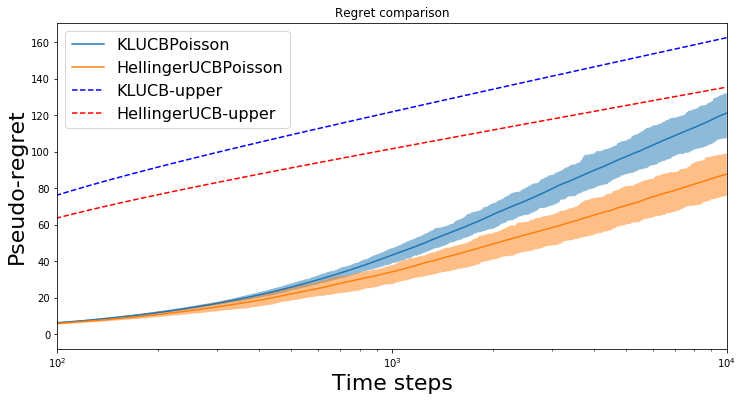

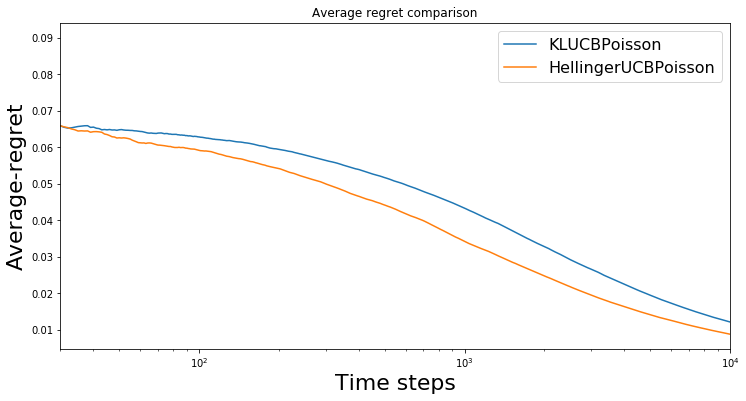

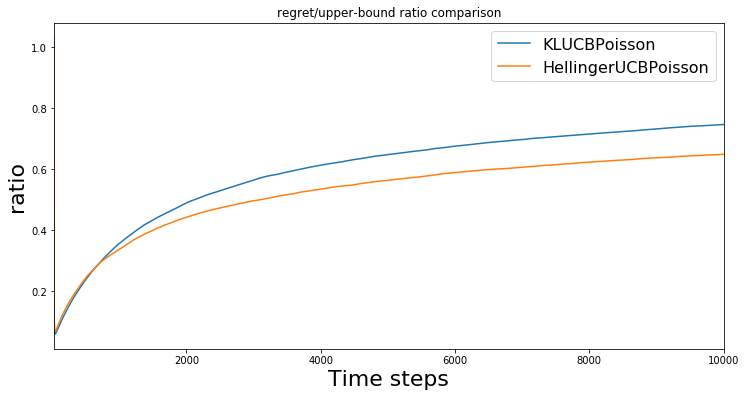

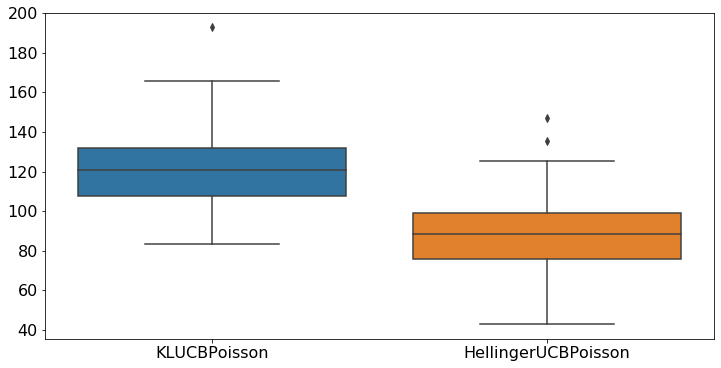

--- 93.74108910560608 seconds ---


In [29]:
start_time = time.time()#Bernoulli
rgrt01, pos01, num_modify01, regrets01, cumu_curve01, ucb01 = parallel(fpolicies, kargs, ntrial, nround, narm, mean, std, game, cores)
print("--- %s seconds ---" % (time.time() - start_time))

In [38]:
game = 'Poisson'
narm = 7
fpolicies = []; kargs = []
fpolicies.append(PolicyKLUCBPoisson); kargs.append(0)
fpolicies.append(PolicyHellingerUCBPoisson); kargs.append(0)
ntrial = 10#number of trials for each core
nround = 10000
mean = numpy.array([0.03]*2+[0.04]*2+[0.05]*2+[0.1])
std = 1
cores = 20
plt.rcParams["figure.figsize"] = (12,6)

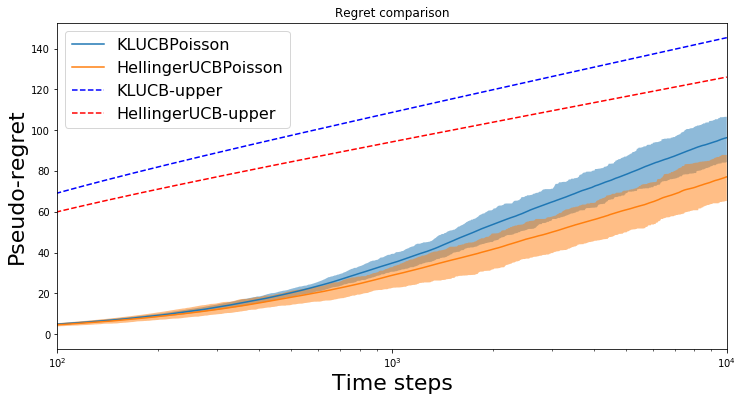

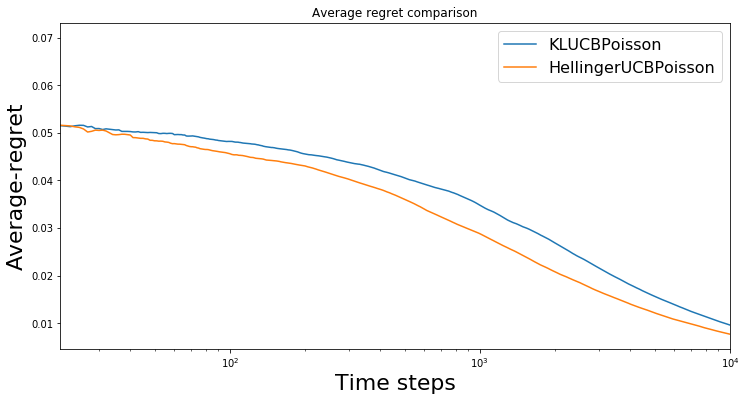

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide


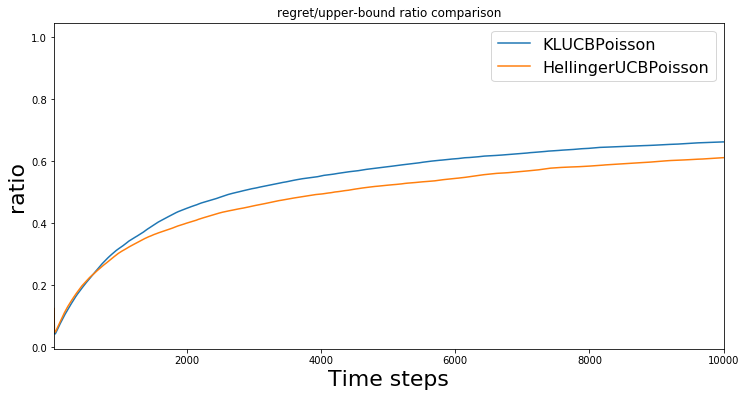

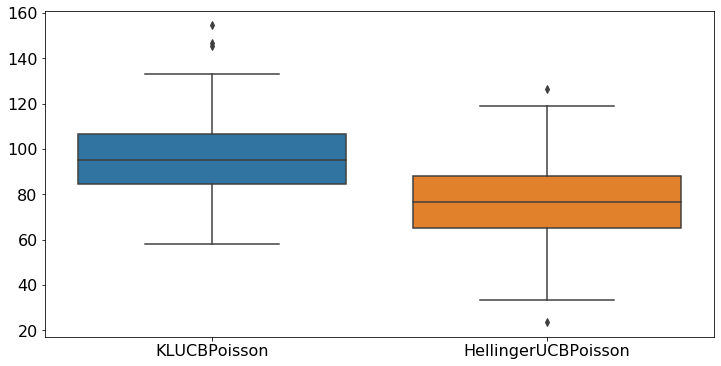

--- 67.81312823295593 seconds ---


In [39]:
start_time = time.time()#Poisson
rgrt02, pos02, num_modify02, regrets02, cumu_curve02, ucb02 = parallel(fpolicies, kargs, ntrial, nround, narm, mean, std, game, cores)
print("--- %s seconds ---" % (time.time() - start_time))